# Notebook 02: Tuning & Calibration

This notebook sweeps hyperparameters for the **rule-based z-score detector** and **Isolation Forest**, so we can choose good defaults. Results are saved for later notebooks/scripts.

In [1]:

import os, sys, itertools, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import IsolationForest

from src.sim import simulate_temperature_series
from src.features import add_rolling_features, make_windowed_matrix

plt.rcParams["figure.figsize"] = (10, 4)
pd.set_option("display.max_rows", 200)


In [2]:

USE_SAVED = False  # set to True if you saved a CSV and want to load it

if USE_SAVED:
    path = "../data/processed/simulated_with_flags.csv"
    df = pd.read_csv(path)
    has_truth = "is_anomaly" in df.columns
    if not has_truth:
        raise ValueError("Saved CSV lacks ground-truth labels. Re-run Notebook 01 or generate data here.")
else:
    df = simulate_temperature_series(n=10_000, base_temp=100.0, noise_sigma=0.2, seed=42)

y_true = df["is_anomaly"].astype(int).values
df.head()


,t,temp,is_anomaly,anomaly_type
0,0,100.060943,False,none
1,1,99.792003,False,none
2,2,100.150090,False,none
3,3,100.188113,False,none
4,4,99.609793,False,none


In [3]:

def compute_prf1(y_true, y_pred, valid_mask=None):
    if valid_mask is None:
        valid_mask = np.ones_like(y_pred, dtype=bool)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true[valid_mask], y_pred[valid_mask], average="binary", zero_division=0
    )
    return pr, rc, f1


In [4]:

windows = [20, 50, 100, 150]
thresholds = [3.0, 3.5, 4.0, 4.5, 5.0]

rows = []
for w in windows:
    df_w = add_rolling_features(df, window=w)
    z = df_w[f"zscore_{w}"].values
    valid = ~np.isnan(z)
    for thr in thresholds:
        y_pred = (np.abs(z) >= thr).astype(int)
        pr, rc, f1 = compute_prf1(y_true, y_pred, valid)
        rows.append({"method":"rule", "window":w, "thresh":thr,
                     "precision":pr, "recall":rc, "f1":f1})

rule_results = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
rule_results.head(10)


,method,window,thresh,precision,recall,f1
0,rule,150,3.0,0.490566,0.011295,0.022081
1,rule,100,3.0,0.387755,0.008254,0.016163
2,rule,50,3.0,0.432432,0.006950,0.013681
3,rule,150,3.5,0.576923,0.006516,0.012887
4,rule,150,4.0,0.500000,0.003910,0.007759
5,rule,100,3.5,0.444444,0.003475,0.006897
6,rule,20,3.0,0.411765,0.003041,0.006037
7,rule,50,3.5,0.600000,0.002606,0.005190
8,rule,100,4.0,0.500000,0.002606,0.005186
9,rule,150,4.5,0.500000,0.002606,0.005186


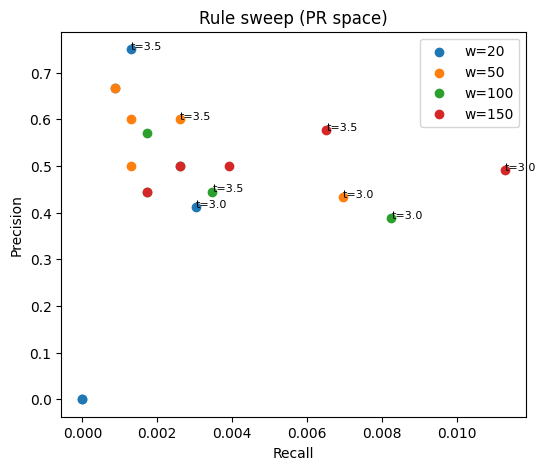

In [5]:

plt.figure(figsize=(6,5))
for w in sorted(rule_results["window"].unique()):
    subset = rule_results[rule_results["window"] == w]
    plt.scatter(subset["recall"], subset["precision"], label=f"w={w}")
    top = subset.sort_values("f1", ascending=False).head(2)
    for _, r in top.iterrows():
        plt.annotate(f"t={r.thresh}", (r.recall, r.precision), fontsize=8)

plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Rule sweep (PR space)")
plt.legend()
plt.show()


In [6]:

wins = [30, 50, 80, 120]
contams = [0.01, 0.02, 0.03, 0.05]
n_estimators = 200

rows = []
for w in wins:
    X = make_windowed_matrix(df["temp"].values, window=w)
    if len(X) == 0:
        continue
    for c in contams:
        iso = IsolationForest(n_estimators=n_estimators, contamination=c, random_state=42)
        iso.fit(X)
        preds = iso.predict(X)

        start = w // 2
        centers = np.arange(start, start + len(X))
        y_if = np.zeros(len(df), dtype=int)
        y_if[centers] = (preds == -1).astype(int)

        pr, rc, f1 = compute_prf1(y_true, y_if)
        rows.append({"method":"IF", "window":w, "contam":c, "n_estimators":n_estimators,
                     "precision":pr, "recall":rc, "f1":f1})

if_results = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
if_results.head(10)


,method,window,contam,n_estimators,precision,recall,f1
0,IF,30,0.05,200,0.987976,0.214162,0.352017
1,IF,50,0.05,200,0.973896,0.210686,0.346429
2,IF,80,0.05,200,0.957661,0.206342,0.339528
3,IF,120,0.05,200,0.937247,0.201129,0.331187
4,IF,30,0.03,200,0.983333,0.128149,0.226749
5,IF,50,0.03,200,0.963211,0.125109,0.221453
6,IF,80,0.03,200,0.936242,0.121199,0.214615
7,IF,120,0.03,200,0.909091,0.117289,0.207772
8,IF,30,0.02,200,0.975000,0.084709,0.155875
9,IF,50,0.02,200,0.954774,0.082537,0.151939


In [7]:

best_rule = rule_results.iloc[0].to_dict()
best_if    = if_results.iloc[0].to_dict()

print("Best rule:", best_rule)
print("Best IF:", best_if)

best = {
    "rule": {"window": int(best_rule["window"]), "thresh": float(best_rule["thresh"])},
    "iforest": {"window": int(best_if["window"]), "contam": float(best_if["contam"]),
                "n_estimators": int(best_if["n_estimators"])},
}
os.makedirs("../data/processed", exist_ok=True)
with open("../data/processed/best_params.json", "w") as f:
    json.dump(best, f, indent=2)
best


Best rule: {'method': 'rule', 'window': 150, 'thresh': 3.0, 'precision': 0.49056603773584906, 'recall': 0.011294526498696786, 'f1': 0.02208067940552017}
Best IF: {'method': 'IF', 'window': 30, 'contam': 0.05, 'n_estimators': 200, 'precision': 0.9879759519038076, 'recall': 0.21416159860990444, 'f1': 0.3520171367368797}


{'rule': {'window': 150, 'thresh': 3.0},
 'iforest': {'window': 30, 'contam': 0.05, 'n_estimators': 200}}

Rule  (w=150, t=3.00): P=0.491 R=0.011 F1=0.022
IF    (w=30, c=0.050): P=0.988 R=0.214 F1=0.352


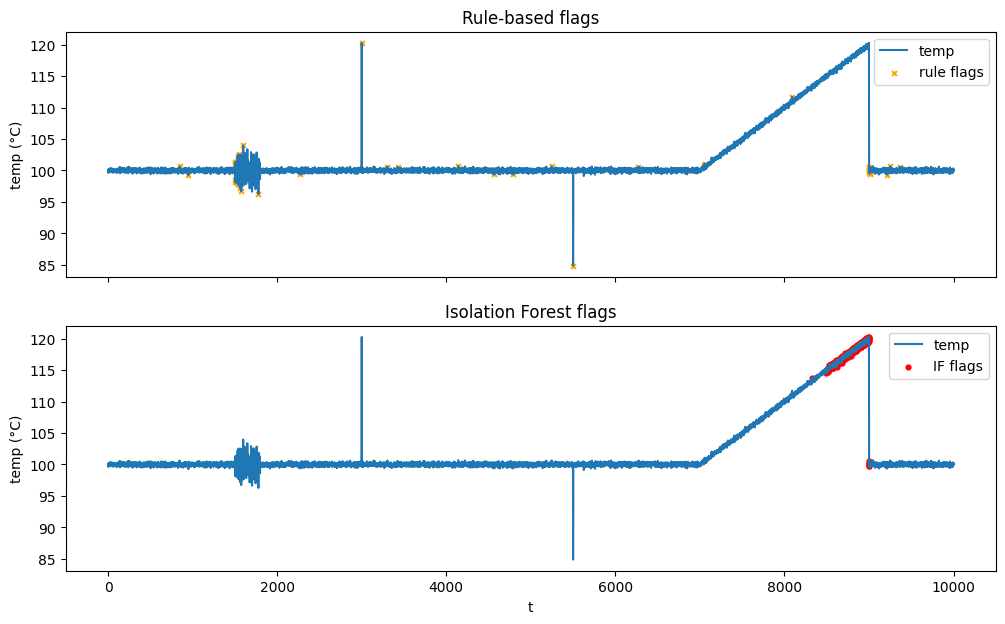

In [8]:

w_rule = best["rule"]["window"]
thr    = best["rule"]["thresh"]
df_r = add_rolling_features(df, window=w_rule)
z = df_r[f"zscore_{w_rule}"].values
rule_preds = (np.abs(z) >= thr).astype(int)

w_if = best["iforest"]["window"]
X = make_windowed_matrix(df["temp"].values, window=w_if)
iso = IsolationForest(n_estimators=best["iforest"]["n_estimators"],
                      contamination=best["iforest"]["contam"], random_state=42)
iso.fit(X)
preds = iso.predict(X)
y_if = np.zeros(len(df), dtype=int)
start = w_if // 2
centers = np.arange(start, start + len(X))
y_if[centers] = (preds == -1).astype(int)

pr_r, rc_r, f1_r = compute_prf1(y_true, rule_preds, ~np.isnan(z))
pr_i, rc_i, f1_i = compute_prf1(y_true, y_if)
print(f"Rule  (w={w_rule}, t={thr:.2f}): P={pr_r:.3f} R={rc_r:.3f} F1={f1_r:.3f}")
print(f"IF    (w={w_if}, c={best['iforest']['contam']:.3f}): P={pr_i:.3f} R={rc_i:.3f} F1={f1_i:.3f}")

fig, axes = plt.subplots(2, 1, figsize=(12,7), sharex=True)

axes[0].plot(df["t"], df["temp"], label="temp")
axes[0].scatter(df.index[rule_preds==1], df["temp"][rule_preds==1], s=12, label="rule flags", color="orange", marker="x")
axes[0].set_title("Rule-based flags")
axes[0].legend()

axes[1].plot(df["t"], df["temp"], label="temp")
axes[1].scatter(df.index[y_if==1], df["temp"][y_if==1], s=12, label="IF flags", color="red", marker="o")
axes[1].set_title("Isolation Forest flags")
axes[1].legend()

axes[1].set_xlabel("t"); axes[0].set_ylabel("temp (°C)"); axes[1].set_ylabel("temp (°C)")
plt.show()


In [9]:

out_dir = "../data/processed"
os.makedirs(out_dir, exist_ok=True)

out = df.copy()
out["pred_rule"] = rule_preds
out["pred_if"] = y_if
csv_path = os.path.join(out_dir, "tuned_predictions.csv")
out.to_csv(csv_path, index=False)
csv_path


'../data/processed/tuned_predictions.csv'